In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as la
from scipy . interpolate import UnivariateSpline
import scipy.integrate as integ
from scipy.optimize import root

# Elementos finitos en una dimensión

Vamos a estudiar la técnica de los elementos finitos, comenzando por problemas de contorno en una dimensión espacial para entender bien la técnica.

## Problemas de contorno

Estudiamos problemas de contorno para ecuaciones diferenciales ordinarias. La variable respecto de la que derivamos _típicamente_ no representa el tiempo, sino que modelizamos problemas estacionarios en una dimensión espacial.
Aunque se pueden definir problemas de contorno de interés con la variable temporal

Comenzamos con una sóla ecuación diferencial de segundo orden:
$$
y''(x) = f(x,y(x),y'(x)),
$$
definida para $x$ que varía en un intervalo $[a,b]$. 

Un **problema de contorno** (**boundary value problem** en inglés) para esta ecuación diferencial consiste en encontrar una solución $y(x)$ de la ecuación cuyos valores están prescritos en los extremos del intervalo:

$$
y''(x) = f(x,y(x),y'(x)),\quad a\leq x\leq b,\quad  y(a)=\alpha, y(b)=\beta
$$

Las condiciones 

$$y(a)=\alpha, y(b)=\beta$$

se llaman **condiciones de contorno** (**boundary conditions**). Estas condiciones se conocen como condiciones de Dirichlet. 

No son el único tipo de condiciones de contorno que nos podemos encontrar. Son muy comunes las condiciones de Neumann:

$$y'(a)=\alpha, y'(b)=\beta$$

en las que interviene la derivada. O las condiciones de tipo Robin:

$$y'(a)=\alpha y(a), y'(b)=\beta y(b)$$

e incluso una combinación de condiciones de tipo Dirichlet, Neumann o Robin en los dos extremos del intervalo.

Es importante comparar el __problema de contorno (PC)__:
con el __problema de valor de inicial (PVI)__ para la misma ecuación diferencial. Recordemos que el **problema de valor inicial**  consiste en encontrar la solución de la ecuación diferencial que cumple que $y(x_0)$ y la derivada $y'(x_0)$ son valores prescritos para un mismo punto $x_0\in [a,b]$. Si $x_0=a$ esto no es más que:

$$
y''(x) = f(x,y(x),y'(x)),\quad a\leq x\leq b,\quad y(a)=\alpha, y'(a)=\beta
$$

La __teoría__ de los problemas de contorno es distinta a la de los de los problemas de valor inicial: problemas muy regulares pueden tener más de una solución, o no tener ninguna. _La solución única al problema de contorno expuesto más adelante está garantizada_ cuando $f$ es derivable con respecto a las variables $y,y'$ y además, para todos los valores donde $f$ está definida se cumple:
 - $\frac{\partial f}{\partial y} > 0,$
 - $|\frac{\partial f}{\partial y'}| < M$
 

## Ejemplo

Representamos el desplazamiento vertical de una viga horizontal mediante una función $w(x)$ que indica el desplazamiento vertical en la posición $x$ medida desde el extremo izquierdo de la viga.

![viga](viga.png)

La siguiente ecuación modeliza el desplazamiento vertical $w$ de una viga con carga homogénea y sujeta en los dos extremos:

$$
w''(x) = \frac{S}{EI}w(x) - \frac{q}{2EI}x(x-l)\quad 0<x<l
$$
$$
w(0)=w(l)=0,
$$
donde
 - $l$: longitud de la viga
 - $E$: módulo elástico de la viga
 - $I$: momento de inercia de la sección de la viga
 - $S$: tensión horizontal en los extremos de la viga
 - $q$: carga de la viga por unidad de longitud

Fijamos los valores $l=120, E=3\cdot 10^{7}, S=1000, I=625$ (en unidades compatibles que no especificamos).

Se espera que el desplazamiento cumpla $w(x)<0$ como se muestra en la figura.

## `integ.solve_bvp` 

Resolvemos el problema con `integ.solve_bvp`, método de la librería `scipy` para resolver problemas de contorno _en una dimensión espacial_. La sintaxis no es tan intuitiva como la de `integ.solve_ivp` (`:-/`)
```python
integ.solve_bvp(
    fun, # función que define la ecuación diferencial
    bc,  # función que define las condiciones de frontera, que pueden ser bastante generales
    xs,  # un array con valores para la variable independiente x
    ys   # un "primer intento" (initial guess) para los valores de y en los puntos de xs
)
```

In [2]:
integ.solve_bvp?

Signature:
integ.solve_bvp(
    fun,
    bc,
    x,
    y,
    p=None,
    S=None,
    fun_jac=None,
    bc_jac=None,
    tol=0.001,
    max_nodes=1000,
    verbose=0,
    bc_tol=None,
)
Docstring:
Solve a boundary value problem for a system of ODEs.

This function numerically solves a first order system of ODEs subject to
two-point boundary conditions::

    dy / dx = f(x, y, p) + S * y / (x - a), a <= x <= b
    bc(y(a), y(b), p) = 0

Here x is a 1-D independent variable, y(x) is an N-D
vector-valued function and p is a k-D vector of unknown
parameters which is to be found along with y(x). For the problem to be
determined, there must be n + k boundary conditions, i.e., bc must be an
(n + k)-D function.

The last singular term on the right-hand side of the system is optional.
It is defined by an n-by-n matrix S, such that the solution must satisfy
S y(a) = 0. This condition will be forced during iterations, so it must not
contradict boundary conditions. See [2]_ for the explanation ho

In [2]:
l = 120
Q = 100
E = 3e7
S = 1e3
I = 625

def fun(x,ys):
    'Define la EDO'
    y, yp = ys
    return [yp, (S/(E*I))*y  - (Q/(2*E*I))*x*(x-l)]

# Las condiciones en los extremos
a, b = 0, l
alpha, beta = 0, 0
def bc(vals_a, vals_b):
    #vals_a contains the values y(a) and y'(a)
    ya, ypa = vals_a
    #vals_b contains the values y(b) and y'(b)
    yb, ypb = vals_b
    return np.array([ya - alpha, yb - beta])

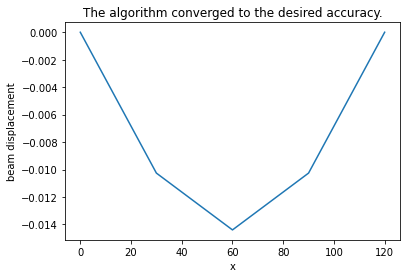

In [3]:
N = 5
xs = np.linspace(0, l, N)
ys = np.zeros((2, N))
sol = integ.solve_bvp(fun, bc, xs, ys)
plt.title(sol['message'])
plt.xlabel('x')
plt.ylabel('beam displacement')
plt.plot(sol['x'], sol['y'][0,:])

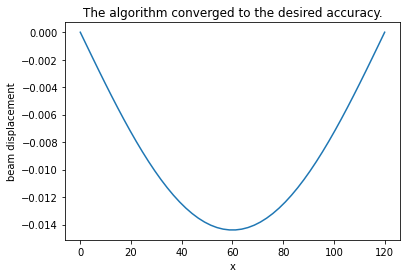

In [4]:
# Repetimos para N=50
N = 50
xs = np.linspace(0, l, N)
ys = np.zeros((2, N))
sol = integ.solve_bvp(fun, bc, xs, ys)
plt.title(sol['message'])
plt.xlabel('x')
plt.ylabel('beam displacement')
plt.plot(sol['x'], sol['y'][0,:])

### Ejercicio

Un análisis más fino permite mejorar el modelo descrito por la ecuación que acabamos de analizar:
$$
w''(x) = \frac{S}{EI}w(x) - \frac{q}{2EI}x(x-l)\; 0<x<l
$$

Más abajo, tenemos otra ecuación que también modeliza los desplazamientos de una viga sujeta en los extremos, bajo una carga uniforme:

$$
\frac{w''(x)}{(1 + w'(x)^2)^{3/2}} = \frac{S}{EI}w(x) - \frac{q}{2EI}x(x-l)\; 0<x<l
$$

Al contrario que la primera, esta ecuación no es lineal y es un modelo más realista para calcular los desplazamientos de la viga.

Sin embargo, se afirma que la ecuación del apartado anterior es una buena aproximación si los desplazamientos son pequeños.

1. Resuelve las dos ecuaciones para los mismos valores de las constantes:

($l=120, E=3\cdot 10^{7}, S=1000, I=625, q=100$).

Calcula el máximo de la diferencia entre la solución encontrada con este método y la encontrada con el anterior. 
    
2. Repite el apartado anterior para una carga $q=100000$.

In [2]:
l = 120
Q = 100
E = 3e7
S = 1e3
I = 625

def fun(x,ys):
    'Define la EDO'
    y, yp = ys
    return [yp, ((S/(E*I))*y  - (Q*x/(2*E*I))*(x-l))]

def fun_NL(x,ys):
    'Define la EDO'
    y, yp = ys
    return [yp, (1+yp**2)**(3/2)*((S/(E*I))*y  - (Q*x/(2*E*I))*(x-l))]

# Las condiciones en los extremos
a, b = 0, l
alpha, beta = 0, 0
def bc(ya, yb):
    return np.array([ya[0] - alpha, yb[0] - beta])

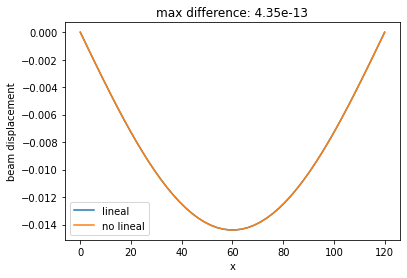

In [3]:
N = 50
xs = np.linspace(0, l, N)
ys = np.zeros((2, N))
sol = integ.solve_bvp(fun, bc, xs, ys)
sol_NL = integ.solve_bvp(fun_NL, bc, xs, ys)
plt.title('max difference: %.2e'%max(np.abs(sol['y'][0,:] - sol_NL['y'][0,:])))
plt.xlabel('x')
plt.ylabel('beam displacement')
plt.plot(sol['x'], sol['y'][0,:], label='lineal')
plt.plot(sol_NL['x'], sol_NL['y'][0,:], label='no lineal')
plt.legend()

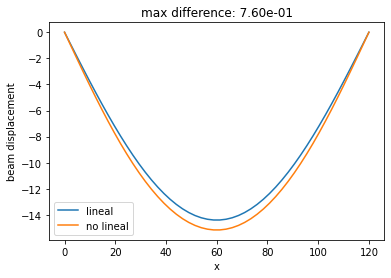

In [4]:
Q = 100000

def fun(x,ys):
    'Define la EDO'
    y, yp = ys
    return [yp, ((S/(E*I))*y  - (Q*x/(2*E*I))*(x-l))]

def fun_NL(x,ys):
    'Define la EDO'
    y, yp = ys
    return [yp, (1+yp**2)**(3/2)*((S/(E*I))*y  - (Q*x/(2*E*I))*(x-l))]

N = 50
xs = np.linspace(0, l, N)
ys = np.zeros((2, N))
sol = integ.solve_bvp(fun, bc, xs, ys)
sol_NL = integ.solve_bvp(fun_NL, bc, xs, ys)
plt.title('max difference: %.2e'%max(np.abs(sol['y'][0,:] - sol_NL['y'][0,:])))
plt.xlabel('x')
plt.ylabel('beam displacement')
plt.plot(sol['x'], sol['y'][0,:], label='lineal')
plt.plot(sol_NL['x'], sol_NL['y'][0,:], label='no lineal')
plt.legend()

### Ejercicio

Resuelve el siguiente problema de contorno:

$$-\epsilon^2\ddot{u}(x) + x^2 u(x) = 1,\quad -1\leq x \leq 1,$$

$$ u(-1) = u(1) = 0, $$

siendo $\epsilon=1$ y representa gráficamente la solución.

Repite este ejercicio tomando $\epsilon = 10^{-n}$ con $n=2,3,4,5$. Representa en una misma gráfica las soluciones correspondientes. 

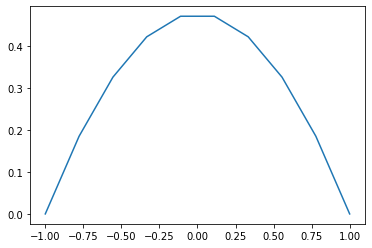

In [5]:
def f(x):
    return 1
def Q(x):
    return x**2
epsilon = 1

def fun(x, y):
    u, v = y
    return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 10
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))
sol = integ.solve_bvp(fun, bc, xs, ys)
plt.plot(sol['x'], sol['y'][0,:])

(0.0, 10000.0)

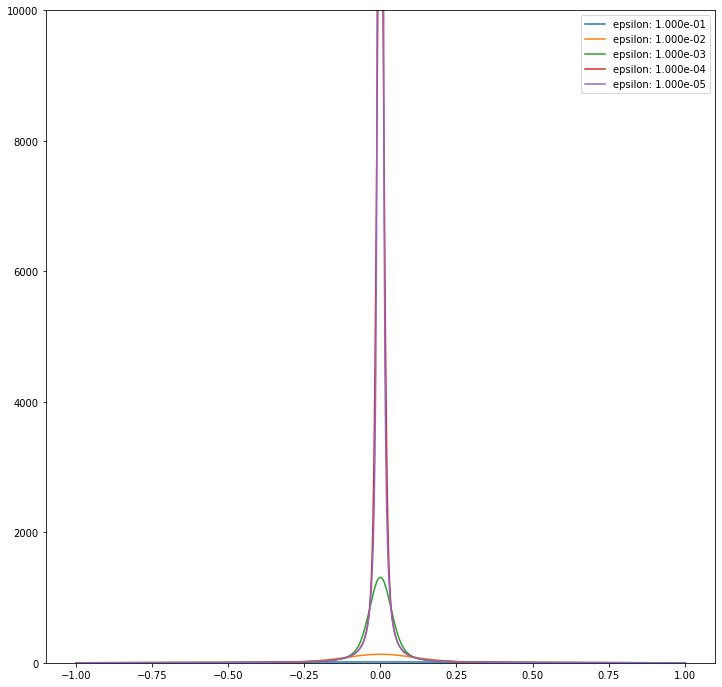

In [6]:
def f(x):
    return 1
def Q(x):
    return x**2
def bc(ya, yb):
    ua, va = ya
    ub, vb = yb
    return np.array([ua, ub])
a, b = -1, 1
n = 10
xs = np.linspace(a, b, n)
ys = np.zeros((2,n))

plt.figure(figsize=(12,12))
for epsilon in [10**(-n) for n in range(1,6)]:
    def fun(x, y):
        u, v = y
        return np.array([v, (1/epsilon**2)*(Q(x)*u - f(x)) ])
    sol = integ.solve_bvp(fun, bc, xs, ys)
    plt.plot(sol['x'], sol['y'][0,:], label='epsilon: %.3e'%epsilon)
plt.legend()
# opcional, pero com ylim se ve más claro el resultado:
plt.ylim(0,1e4)

## Elementos finitos

Al contrario que `solve_bvp`, sólo vamos a estudiar la técnica de los elementos finitos para _problemas lineales_ con una forma concreta (pero que aparece en muchos dominios distintos).

Queremos resolver una ecuación del tipo:

$$
-u'' + Vu = f 
$$

o, escribiendo la variable $x$

$$
-u''(x) + V(x)u(x) = f(x)
$$

en un intervalo $[a,b]$, con condiciones de frontera $u(a)=u(b)=0$.

La ecuación anterior es cierta si y sólo si el producto de $-u''(x) + V(x)u(x) - f(x)$ por cualquier función $v$ tiene integral $0$:

$$
\int_a^b \left(-u''(x) + V(x)u(x) - f(x) \right) v(x) \: d x= 0\;\text{ para cualquier }v.
$$

Esa integral se puede simplificar un poco integrando por partes. Para cualquier $v$ que sea derivable y se anule en los extremos del intervalo $v(a)=v(b)=0$ se tiene que cumplir que

$$
\int_a^b ( u'(x)v'(x) + V(x)u(x)v(x) - f(x) v(x))dx = 0, 
$$

y vemos que esta integral es exactamente la derivada del funcional $E$ en el "punto" $u$ y en la dirección $v$, donde $E$ es un _funcional de energía_ definido en el espacio $\mathbf{V}$ de las funciones derivables que se anulan en los extremos del intervalo (a cada función de $\mathbf{V}$ le asigna un número real):

$$
E(u)=\frac{1}{2}\int_a^b (u'(x)^2 + V(x)u(x)^2)dx - \int_a^b f(x) u(x)dx = 0.
$$

> _Cualquier solución de la ecuación diferencial es un punto crítico del funcional de energía, y viceversa._

$$
-u'' + Vu = f\; \text{ en sentido "débil" en }\mathbf{V}\Leftrightarrow \langle\nabla E(u),v\rangle=0 \text{ para cualquier }v\in \mathbf{V}\Leftrightarrow \nabla E(u)=0.
$$

De hecho, el funcional $E$ es cuadrático y convexo, y tiene un único punto crítico, que es un mínimo.

Fijamos una serie de nodos, que por simplicidad consideramos equiespaciados de paso $h>0$: 
$$a=x_0,x_1,\dots,x_{n-1}, x_{n}=b,\quad x_j=a+hj.$$

Buscamos una solución aproximada en el espacio $\mathbf{V}_h\subset \mathbf{V}$ de todas las funciones $u_h$ que son lineales en cada intervalo $[x_i,x_{i+1}]$, que además valen $0$ en los extremos: $u_h(x_0)=u_h(x_n)=0$.

Cualquier función de $\mathbf{V}_h$ se puede escribir en la forma
$$
u_h(x) = \sum_{i=1}^n c_i\phi_i(x)
$$
Donde $\phi_i$ son funciones que forman una base de $\mathbf{V}_h$. 
La función $\phi_i$ es la única función de $\mathbf{V}_h$ que vale $1$ en $x_i$, y $0$ en todos los demás nodos

![finite_element_d1.png](finite_element_d1.png)
![finite_element_d1_bis.png](finite_element_d1_bis.png)


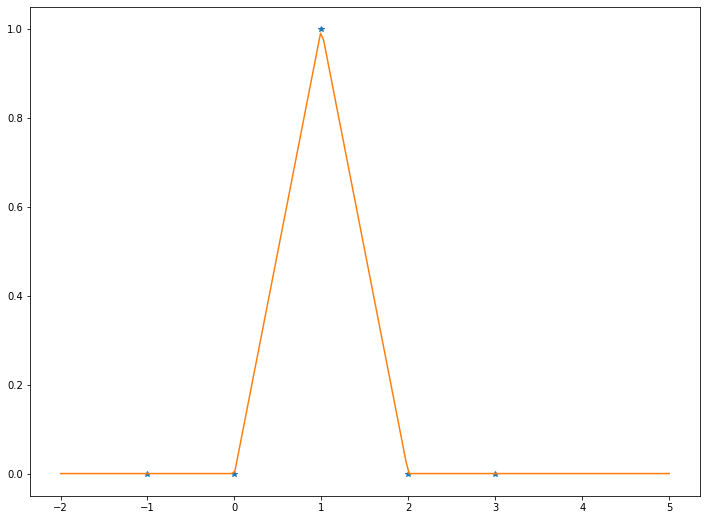

In [7]:
xdata = [-1,0,1,2,3]
ydata = [0,0,1,0,0]

from scipy . interpolate import UnivariateSpline
s = UnivariateSpline(xdata, ydata, k=1, s=0)

x_eval = np.linspace(-2, 5, 200)
y_linear_spline = s(x_eval)

plt.figure(figsize=(12,9))
plt.plot(xdata, ydata, '*', label='nodos de interpolación')
plt.plot(x_eval, y_linear_spline, label='spline lineal')

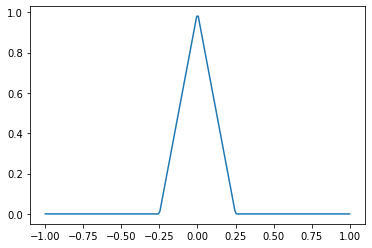

In [8]:
def FE(x1, x2, x3):
    '''Una llamada a FE nos devuelve una función lineal a trozos f
    que vale:
        - f(x1) = f(x3) = 0
        - f(x2) = 1
        - lineal en (x1, x2) y (x2, x3)
        - 0 fuera del intervalo (x1, x3)
    '''
    xdata = [x1-1, x1, x2, x3, x3+1]
    ydata = [0,0,1,0,0]
    # Interpolación lineal a trozos de xdata e ydata
    # continuada por cero entre -oo y x1, y también entre x3 y +oo
    return UnivariateSpline(xdata, ydata, k=1, s=0)

phi = FE(-0.25, 0, 0.25)
x_eval = np.linspace(-1,1,200)
y_eval = phi(x_eval)
plt.plot(x_eval, y_eval)

Si desarrollamos el funcional de energía en esta base tenemos:
$$
\begin{array}{rcll}
E(u_h)&=&\frac{1}{2}\int_a^b ((u'_h(x))^2 + V(x)u_h(x)^2)dx - \int_a^b f(x) u_h(x))dx = 0\\
E\left(\sum_{i=1}^n c_i\phi_i(x)\right)&=&\frac{1}{2}\int_a^b \left(\sum_{i=1}^n c_i\phi_i'(x)\sum_{j=1}^n c_j\phi_j'(x)dx\right) \\
                        &&+ \frac{1}{2}\int_a^b V(x)\left(\sum_{i=1}^n c_i\phi_i(x)\sum_{j=1}^n c_j\phi_j(x)dx\right)\\
                        &&- \int_a^bf(x)\left(\sum_{i=1}^n c_i\phi_i(x)dx\right)  = 0
\end{array}
$$

Esto a su vez, se puede reescribir como:
$$
\begin{array}{rcl}
E\left(\sum_{i=1}^n c_i\phi_i\right)&=& \frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n c_jc_i\int_a^b\phi_i'\phi_j'\right) \\
                        &&+\frac{1}{2}\left(\sum_{i=1}^n \sum_{j=1}^n c_jc_i \int_a^b V\phi_i\phi_j\right)\\
                        &&- \sum_{i=1}^n c_i\int_a^b f\phi_i  = 0.
\end{array}
$$

Concluimos que la energía tiene la siguiente estructura:

$$
\begin{array}{rcll}
E(u_h)=E\left(\sum_{i=1}^n c_i\phi_i\right)=\frac{1}{2}\mathbf{c}^T\cdot A\cdot \mathbf{c} - \mathbf{c}^T\cdot\mathbf{b}
\end{array}
$$

donde 
- El vector $\mathbf{c}$ tiene por coordenada $i$ la incógnita $c_i$.
- La matriz $A$ es una matriz simétrica que tiene por entradas:
$$ a_{ij} := \int_a^b\phi_i'(x)\phi_j'(x)\:dx + \int_a^b V(x)\phi_i(x)\phi_j(x)\:dx.$$
- El vector $\mathbf{b}$ tiene por coordenada $i$ el valor 
$$b_i:=\int_a^b f(x)\phi_i(x)\:dx.$$


Es importante observar que las integrales que definen $A$ se anulan si $j$ no es $i$, $i-1$ ó $i+1$, porque $\phi_{i}(x)$ se anula si $x$ no está en $[x_{i-1}, x_{i+1}]$, y $\phi_{j}(x)$ se anula si $x$ no está en $[x_{j-1}, x_{j+1}]$, luego el producto $\phi_{i}(x)\phi_{j}(x)$ se anula si $x$ no está en la intersección de esos dos intervalos.

Es decir, __la matriz $A$ es tridiagonal__, con $-2$ en la diagonal principal, y $1$ en las dos diagonales adyacentes.

El funcional $E$ es cuadrático y definido positivo, y por tanto tiene un mínimo absoluto en su único punto crítico, que se obtiene derivando e igualando a cero:
$$
\nabla E(\mathbf{c}) = A\cdot \mathbf{c} - \mathbf{b} = \mathbf{0}.
$$
Concluimos que una solución aproximada en $u_h\in\mathbf{V}_h$ de nuestro problema de contorno es de la forma:
$$ u_h(x) = \sum_{i=1}^n c_i\phi_i(x), $$
donde los coeficientes $\mathbf{c}=(c_1,\dots,c_n)$ se obtienen resolviendo un sistema de ecuaciones lineales:
$$
A\cdot \mathbf{c} = \mathbf{b}.
$$

In [9]:
l = 120
Q = 100
E = 3e7
S = 1e3
I = 625

#Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
x0, xf = x_span = [0, l]
alpha, beta = 0, 0

## ATENCION: vamos a escribir la ecuación en la forma
## 
##     - u''(x) + V(x)u(x) = f(x)
##     u(a)=u(b)=0
## 
## esto difiere de la sintaxis usada por solve_bvp en e la que
## se despeja u''

def V(x):
    #Devuelve un array del mismo tamaño que el array xs, toma el valor
    #constante S/(E*I)
    return (S/(E*I))*np.ones_like(x)

def f(x):
    return (Q/(2*E*I))*x*(x-l)

# Probamos distintos valores
n = 120

# Mallado
h = (xf - x0)/n
xs = np.linspace(x0,xf,n+1)
#puntos interiores
xs_int = xs[1:-1]

# Matriz banda A
A = np.zeros((n-1,n-1))
# Vector b
b = np.zeros(n-1)
for i in range(n-1):
    xi = xs_int[i]
    xi_menos = xi - h
    xi_mas   = xi + h
    phi_i = FE(xi_menos, xi, xi_mas)
    A[i,i] = (
        (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
    )
    b[i] = integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
    if i>0:
        phi_i_menos = FE(xi-2*h, xi-h, xi)
        A[i,i-1] = (
        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
        )
    if i<n-2:
        phi_i_mas = FE(xi, xi+h, xi+2*h)
        A[i,i+1] = (
        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
        )

# Solucion
y_int = la.solve(A, b)
ys_FEM = np.zeros(n+1)
# ys_FEM vale 0 en los extremos del intervalo
ys_FEM[1:-1] = y_int

In [14]:
A.round(3)

array([[ 2., -1.,  0., ...,  0.,  0.,  0.],
       [-1.,  2., -1., ...,  0.,  0.,  0.],
       [ 0., -1.,  2., ...,  0.,  0.,  0.],
       ...,
       [ 0.,  0.,  0., ...,  2., -1.,  0.],
       [ 0.,  0.,  0., ..., -1.,  2., -1.],
       [ 0.,  0.,  0., ...,  0., -1.,  2.]])

Recordemos que nuestra aproximación a la solución es
$$
u_h(x)=\sum_{i=1}^n c_i\phi_i(x)
$$
pero como $u_h$ es lineal a trozos, podemos hacer la gráfica de u usando el comando `plot`, que interpola linealmente.
Los valores de $u$ en los nodos son exactamente:
$$
u_h(x_j)=\sum_{i=1}^n c_i\phi_i(x_j) = c_j
$$
porque $\phi_i(x_j)$ vale 0 cuando $i\neq j$ y 1 cuando $i=j$.

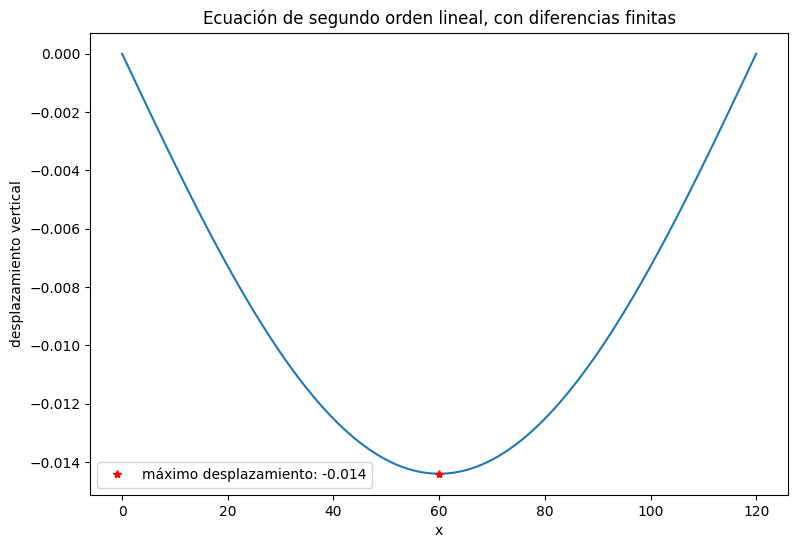

In [15]:
plt.figure(figsize=(9,6))
plt.plot(xs,ys_FEM)
plt.xlabel('x')
plt.ylabel('desplazamiento vertical')
plt.title('Ecuación de segundo orden lineal, con diferencias finitas')
#Se ve a ojo que el máximo desplazamiento se alcanza en el punto medio
#También se puede deducir de la simetría del problema
#Pero este código permite encontrar el máximo de ys (realmente es un mínimo, puesto que el desplazamiento es negativo)
#y el punto donde se alcanza el máximo en general

ymax, xmax = min(zip(ys_FEM, xs))
#Dibujamos el máximo
plt.plot([xmax], [ymax], 'r*', label='máximo desplazamiento: %.3f'%ymax)
plt.legend()
plt.show()

Hacer las integrales con `quad` no es eficiente, porque vamos a hacer los cálculos con un error mucho mayor.

Podemos sustituir esas integrales con una regla de Newton-Cotes (como la regla de Simpson) evaluando en los nodos $x_i$, pero los resultados no son muy buenos.
Por ejemplo, comprobamos que las aproximaciones por Simpson para
$\int_a^b f(x)\phi_i(x)dx$ y para $\int_a^b f(x)\phi_i(x)^2dx$ son exactamente iguales, a pesar de que la segunda integral es claramente inferior:
$$
\int_a^b f(x)\phi_i(x)dx = 
\int_{x_{i-1}}^{x_{i+1}} f(x)\phi_i(x)dx =
(h/6)\left(f(x_{i-1})\phi(x_{i-1}) + 4 f(x_i)\phi(x_i) + f(x_{i+1})\phi(x_{i+1}) \right)
=(4h/6)f(x_i).
$$
$$
\int_a^b f(x)\phi_i(x)^2dx = 
\int_{x_{i-1}}^{x_{i+1}} f(x)\phi_i(x)^2dx =
(h/6)\left(f(x_{i-1})\phi(x_{i-1})^2 + 4 f(x_i)\phi(x_i)^2 + f(x_{i+1})\phi(x_{i+1})^2 \right)
=(4h/6)f(x_i).
$$


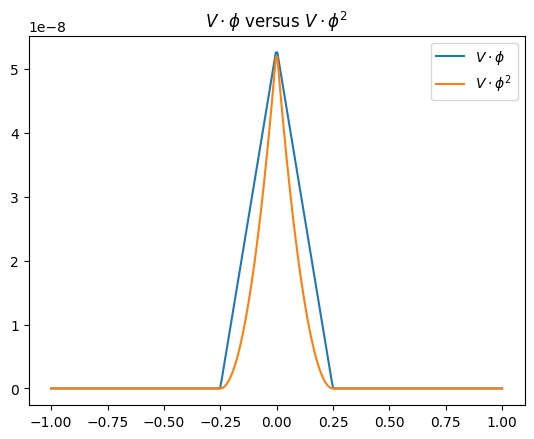

In [16]:
xs = np.linspace(-1,1,300)
x0 = 0
h = 0.25
phi = FE(x0-h,x0,x0+h)
integrando1 = lambda x: V(x)*phi(x)
integrando2 = lambda x: V(x)*phi(x)**2
ys1 = integrando1(xs)
ys2 = integrando2(xs)
plt.plot(xs, ys1, label='$V\cdot\phi$')
plt.plot(xs, ys2, label='$V\cdot\phi^2$')
plt.title('$V\cdot\phi$ versus $V\cdot\phi^2$')
plt.legend()

Una idea aún mejor es sustituir $f$ por su aproximación en el espacio $\mathbf{V}_h$ (funciones lineales en cada intervalo $[x_i,x_{i+1}]$):
$$
f(x)\approx\sum_{i=1}^n f(x_i)\phi_i(x)
$$
Las funciones $f(x)$ y $\sum_{i=1}^n f(x_i)\phi_i(x)$ toman los mismos valores en todos los nodos $x_i$.

Hacemos las integrales:
$$
\int_a^b f(x)\phi_j(x)dx \approx 
\int_a^b \sum_{i=1}^n f(x_i)\phi_i(x) \phi_j(x)dx =
\sum_{i=1}^n f(x_i)\int_a^b \phi_i \phi_j.
$$
Las integrales $\int_a^b \phi_i(x) \phi_j(x)dx$ son fáciles de hacer a mano (y recordamos que sólo tres de ellas son distintas de cero). Algo similar se puede hacer con las integrales $\int_a^b V(x)\phi_i(x)\phi_{j}(x)dx$.

Resumimos los resultados:
 - $\int_a^b f(x)\phi_j(x)dx\approx (h/6)\left(f(x_{j-1}) + 4 f(x_j) + f(x_{j+1})\right)$,
 - $\int_a^b \phi_j'(x)^2dx = (2/h)$,
 - $\int_a^b \phi_j'(x)\phi_{j+1}'(x)dx = (-1/h)$,
 - $\int_a^b V(x)\phi_j(x)^2dx\approx (h/12)\left(V(x_{j-1}) + 6 V(x_j) + V(x_{j+1})\right)$,
 - $\int_a^b V(x)\phi_j(x)\phi_{j+1}(x)dx \approx (h/12)\left(V(x_j) + V(x_{j+1})\right).$

### Ejercicio

Reescribe el método de los elementos finitos sustituyendo todas las integrales con `quad` por las aproximaciones anteriores.

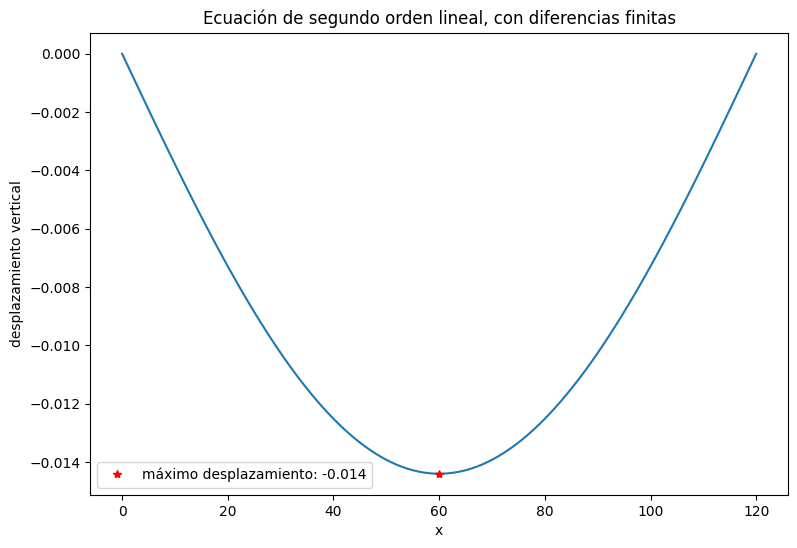

In [17]:
l = 120
Q = 100
E = 3e7
S = 1e3
I = 625

#Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
x0, xf = x_span = [0, l]
alpha, beta = 0, 0

## ATENCION: vamos a escribir la ecuación en la forma
## 
##     - u''(x) + V(x)u(x) = f(x)
##     u(a)=u(b)=0
## 
## esto difiere de la sintaxis usada por solve_bvp en e la que
## se despeja u''

def V(x):
    #Devuelve un array del mismo tamaño que el array xs, toma el valor
    #constante S/(E*I)
    return (S/(E*I))*np.ones_like(x)

def f(x):
    return (Q/(2*E*I))*x*(x-l)

# Probamos distintos valores
n = 120

# Mallado
h = (xf - x0)/n
xs = np.linspace(x0,xf,n+1)
#puntos interiores
xs_int = xs[1:-1]

# Matriz banda A
A = np.zeros((n-1,n-1))
# Vector b
b = np.zeros(n-1)
for i in range(n-1):
    xi = xs_int[i]
    xi_menos = xi - h
    xi_mas   = xi + h
    phi_i = FE(xi_menos, xi, xi_mas)
    A[i,i] = (
#        (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
        (2/h) + (h/12)*(V(xi_menos) + 6*V(xi) + V(xi_mas))
    )
#    b[i] = integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
    b[i] = (h/6)*(f(xi_menos) + 4*f(xi) + f(xi_mas))
    if i>0:
        phi_i_menos = FE(xi-2*h, xi-h, xi)
        A[i,i-1] = (
#        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
        (-1/h) + (h/12)*(V(xi_menos) + V(xi))
        )
    if i<n-2:
        phi_i_mas = FE(xi, xi+h, xi+2*h)
        A[i,i+1] = (
#        (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
        (-1/h) + (h/12)*(V(xi) + V(xi_mas))
        )

# Solucion
y_int = la.solve(A, b)
ys_FEM = np.zeros(n+1)
# ys_FEM vale 0 en los extremos del intervalo
ys_FEM[1:-1] = y_int

#Ponemos signo negativo al desplazamiento, ya que es más intuitivo 
#graficar el desplazamiento hacia abajo
plt.figure(figsize=(9,6))
plt.plot(xs,ys_FEM)
plt.xlabel('x')
plt.ylabel('desplazamiento vertical')
plt.title('Ecuación de segundo orden lineal, con diferencias finitas')
#Se ve a ojo que el máximo se alcanza en el punto medio
#También se puede deducir de la simetría del problema
#Pero este código permite encontrar el máximo de ys 
#y el punto donde se alcanza el máximo en general
ymax, xmax = min(zip(ys_FEM, xs))
#Dibujamos el máximo
plt.plot([xmax], [ymax], 'r*', label='máximo desplazamiento: %.3f'%ymax)
plt.legend()
plt.show()

### Ejercicio

Utiliza el método de los elementos finitos para resolver el siguiente problema de contorno:

$$-\epsilon^2\ddot{u}(x) + x^2 u(x) = 1,\quad -1\leq x \leq 1,$$

$$ u(-1) = u(1) = 0, $$

siendo $\epsilon = 10^{-n}$ con $n=1,2,3,4,5$. Representa en una misma gráfica las soluciones correspondientes. 

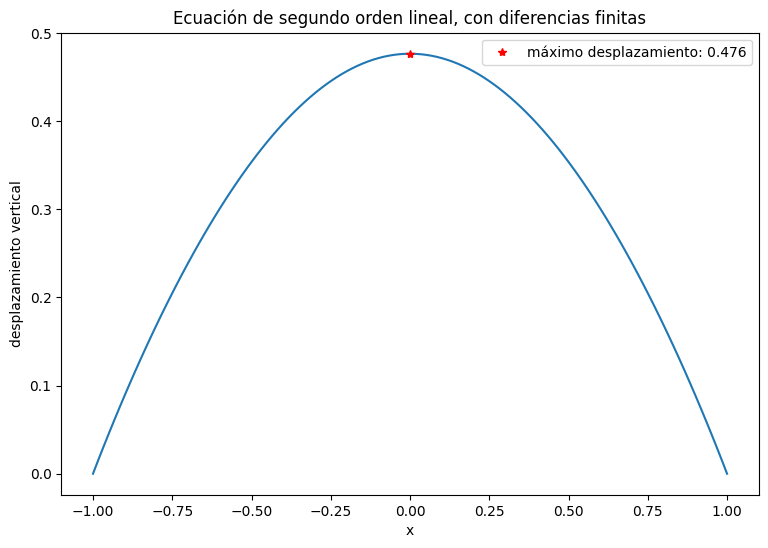

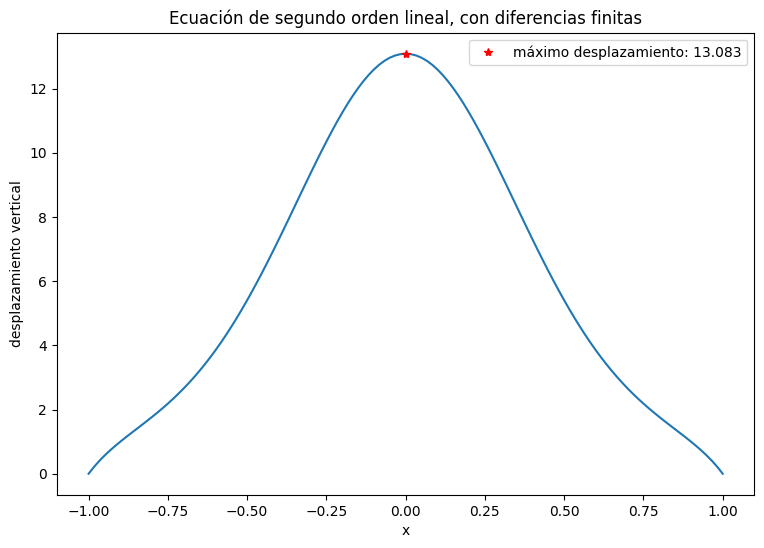

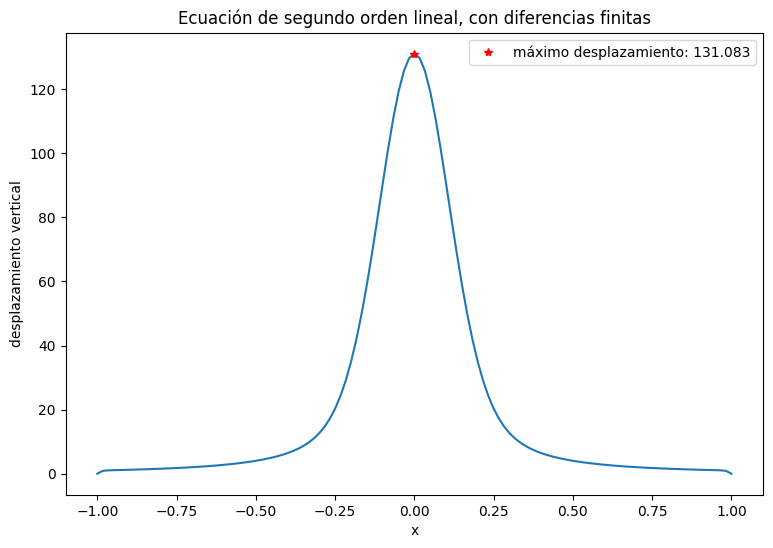

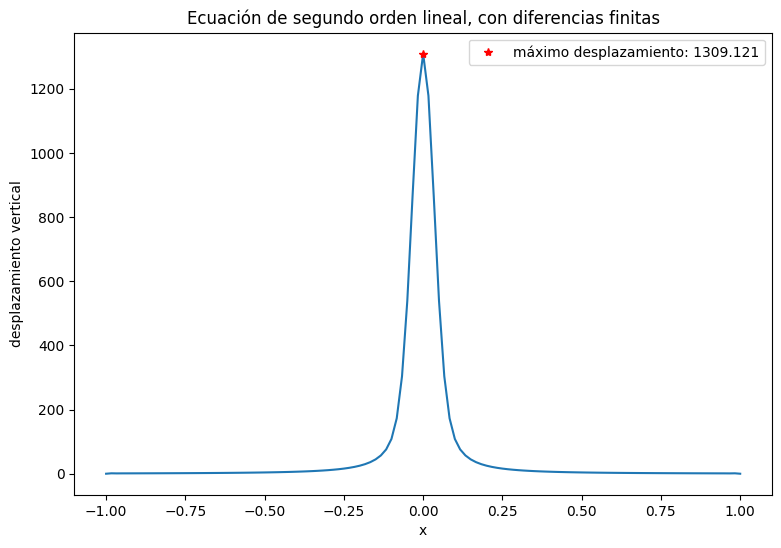

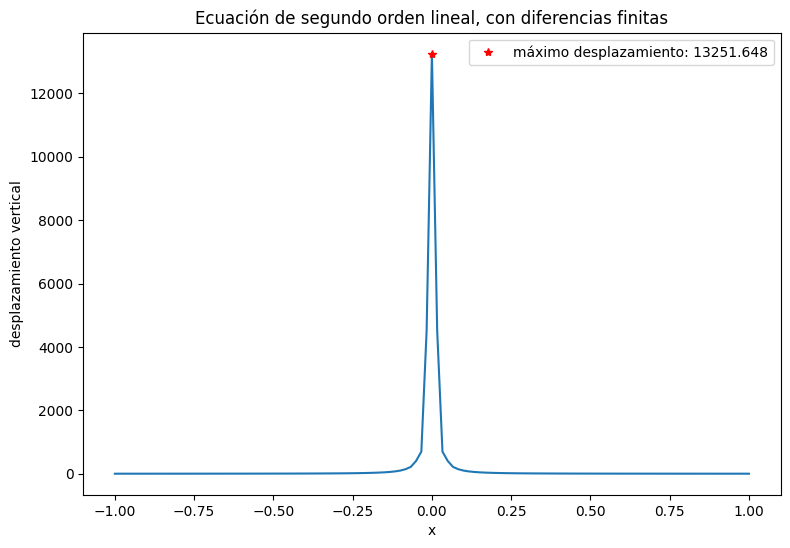

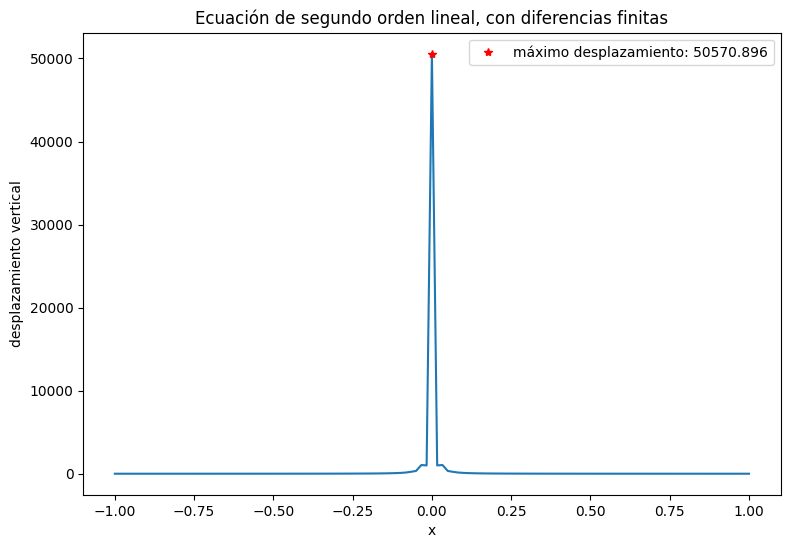

In [18]:
for epsilon in [10**(-n) for n in range(0,6)]:

    #Esta línea define x0, xf (números) y x_span (una lista con esos dos mismos números)
    x0, xf = x_span = [-1, 1]
    alpha, beta = 0, 0

    ## ATENCION: vamos a escribir la ecuación en la forma
    ## 
    ##     - u''(x) + V(x)u(x) = f(x)
    ##     u(a)=u(b)=0
    ## 
    ## esto difiere de la sintaxis usada por solve_bvp en e la que
    ## se despeja u''

    def V(x):
        #Devuelve un array del mismo tamaño que el array xs, toma el valor
        #constante S/(E*I)
        return (1/epsilon**2)*x**2

    def f(x):
        return (1/epsilon**2)*np.ones_like(x)

    # Probamos distintos valores
    n = 120

    # Mallado
    h = (xf - x0)/n
    xs = np.linspace(x0,xf,n+1)
    #puntos interiores
    xs_int = xs[1:-1]

    # Matriz banda A
    A = np.zeros((n-1,n-1))
    # Vector b
    b = np.zeros(n-1)
    for i in range(n-1):
        xi = xs_int[i]
        xi_menos = xi - h
        xi_mas   = xi + h
        phi_i = FE(xi_menos, xi, xi_mas)
        A[i,i] = (
            (2/h) + integ.quad(lambda x: V(x)*phi_i(x)**2, xi_menos,xi_mas)[0]
        )
        b[i] = integ.quad(lambda x: f(x)*phi_i(x), xi_menos,xi_mas)[0]
        if i>0:
            phi_i_menos = FE(xi-2*h, xi-h, xi)
            A[i,i-1] = (
            (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_menos(x), xi_menos,xi)[0]
            )
        if i<n-2:
            phi_i_mas = FE(xi, xi+h, xi+2*h)
            A[i,i+1] = (
            (-1/h) + integ.quad(lambda x: V(x)*phi_i(x)*phi_i_mas(x), xi,xi_mas)[0]
            )

    # Solucion
    y_int = la.solve(A, b)
    ys_FEM = np.zeros(n+1)
    # ys_FEM vale 0 en los extremos del intervalo
    ys_FEM[1:-1] = y_int

    #Ponemos signo negativo al desplazamiento, ya que es más intuitivo 
    #graficar el desplazamiento hacia abajo
    plt.figure(figsize=(9,6))
    plt.plot(xs,ys_FEM)
    plt.xlabel('x')
    plt.ylabel('desplazamiento vertical')
    plt.title('Ecuación de segundo orden lineal, con diferencias finitas')
    #Se ve a ojo que el máximo se alcanza en el punto medio
    #También se puede deducir de la simetría del problema
    #Pero este código permite encontrar el máximo de ys 
    #y el punto donde se alcanza el máximo en general
    ymax, xmax = max(zip(np.abs(ys_FEM), xs))
    #Dibujamos el máximo
    plt.plot([xmax], [ymax], 'r*', label='máximo desplazamiento: %.3f'%ymax)
    plt.legend()
    plt.show()